In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

## Data Preprocessing

In [3]:
train_data = pd.read_csv('train.csv')
train_data.head()

,emotion,pixels,id
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,0.0
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,1.0
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,2.0
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,3.0
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,4.0


In [4]:
train_data['pixels'] = train_data['pixels'].apply(lambda x: list(map(int, x.split(' '))))
train_data['count'] = train_data['pixels'].apply(lambda x: len(x))
train_data = train_data.drop(index=train_data.loc[train_data['count'] != 2304].index)

In [8]:
X_train = torch.tensor(train_data['pixels'].values.tolist(), dtype=torch.float32)
y_train = torch.tensor(train_data['emotion'].values)

X_train = X_train.reshape(3999, 1, 48, 48)
y_train = y_train.type(torch.LongTensor)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')


X_train shape: torch.Size([3999, 1, 48, 48])
y_train shape: torch.Size([3999])


## Visualizing some images from train dataset

In [9]:
import matplotlib.pyplot as plt

In [10]:
def show_grayscale_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('on')
    plt.show()

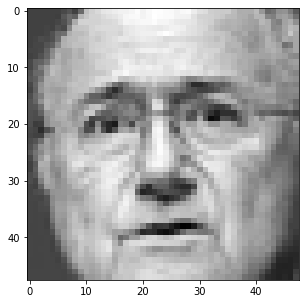

In [11]:
show_grayscale_image(X_train[5].reshape(48, 48))

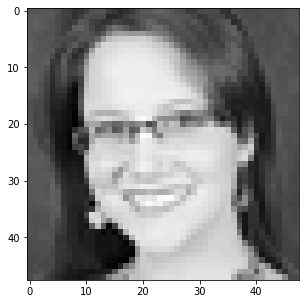

In [12]:
show_grayscale_image(X_train[7].reshape(48, 48))

## Creating Dataset class and DataLoader

In [13]:
class DataSet(Dataset):
  def __init__(self, X_train, y_train):
    self.x_train = X_train
    self.y_train = y_train

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self, index):
    return self.x_train[index], self.y_train[index]

In [14]:
emotions_data = DataSet(X_train, y_train)
train_loader = DataLoader(emotions_data, batch_size=16, shuffle=True)

## Creating NN Architecture

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class EmotionsNeuralNetwork(nn.Module):
    def __init__(self):
      super().__init__()
      self.network = nn.Sequential(
          nn.Conv2d(1, 64, 3, padding=1),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.15),

          nn.Conv2d(64, 128, 3, padding=1),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.15),

          nn.Conv2d(128, 256, 3, padding=1),
          nn.BatchNorm2d(256),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.15),

          nn.Flatten(),
          nn.Linear(9216, 256),
          nn.ReLU(),
          nn.Dropout(0.15),
          nn.Linear(256, 7)
      )

    def forward(self, x):
        return self.network(x)

model = EmotionsNeuralNetwork()

## Choosing Loss Ann Optimizer

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    # 1. Forward pass
    pred = model(X)

    # 2. Evaluating loss
    y = y.squeeze()
    loss = loss_fn(pred, y)
    
    # 3. Backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return loss.item()

In [50]:
val_data = pd.read_csv('val.csv')
val_data['pixels'] = val_data['pixels'].apply(lambda x: list(map(int, x.split(' '))))
val_data['count'] = val_data['pixels'].apply(lambda x: len(x))
val_data = val_data.drop(index=val_data.loc[val_data['count'] != 2304].index)

def calculate_accuracy(val_data, model):
  X_val = torch.tensor(val_data['pixels'].values.tolist(), dtype=torch.float32)
  X_val = X_val.reshape(3589, 1, 48, 48)
  y_right = val_data['emotion'].values

  pred_classes = torch.softmax(model(X_val), dim=1).argmax(dim=1)
  y_right = torch.tensor(y_right)

  a = pred_classes == y_right
  return a.sum() / len(a)

Training model process.


  0%|          | 0/50 [00:00<?, ?it/s]

(0.0, 1.0)

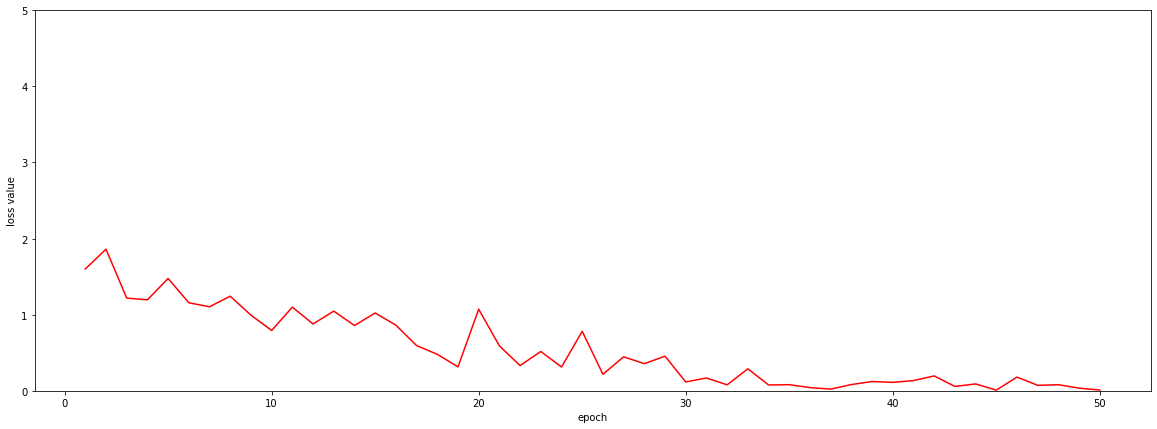

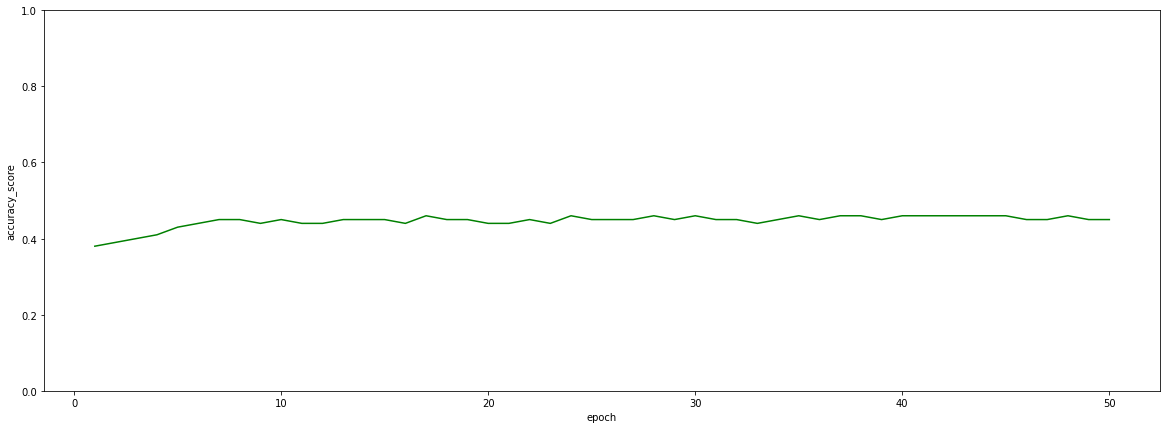

In [51]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

loss_list = []
accuracy_list = []
current_epoch = []

epochs = 50

print('Training model process.')
for epoch in tqdm(range(1, epochs+1)):
  model.train()
  loss = train_loop(train_loader, model, loss_fn, optimizer)

  loss_list.append(loss)
  current_epoch.append(epoch)

  model.eval()
  accuracy = round(calculate_accuracy(val_data, model).item(), 2)
  accuracy_list.append(accuracy)

# plotting loss values per each epoch
plt.figure(0, figsize=(20,7))
plt.plot(current_epoch, loss_list, color='red')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.ylim(0, 5)

# plotting accuracy per each epoch
plt.figure(1, figsize=(20,7))
plt.plot(current_epoch, accuracy_list, color='green')
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
plt.ylim(0, 1)

In [3]:
test_data = pd.read_csv('test.csv')

In [4]:
test_data['pixels'] = test_data['pixels'].apply(lambda x: list(map(int, x.split(' '))))
test_data['count'] = test_data['pixels'].apply(lambda x: len(x))
test_data = test_data.drop(index=test_data.loc[test_data['count'] != 2304].index)

In [5]:
X_test = torch.tensor(test_data['pixels'].values.tolist(), dtype=torch.float32)
X_test = X_test.reshape(3589, 1, 48, 48)

In [6]:
X_test.shape

torch.Size([3589, 1, 48, 48])

In [8]:
test_preds = model(X_test)
test_preds

tensor([[ -1.5776,   0.6838,   3.2364,  ...,   1.0092,   1.0060,  -1.4588],
        [  3.8070,  -2.1167,  -3.8207,  ...,  -1.5086,  -3.2932,   3.8585],
        [  3.9484,  -0.2781,   7.6193,  ...,   0.6115,  -3.0434,  -2.4292],
        ...,
        [ -2.6954,  -8.0161,   0.9998,  ...,   6.6511, -11.8787,  12.5525],
        [  2.3229,  -4.6593,  -2.0427,  ...,   8.1171,  -1.4890,  -2.7009],
        [ -0.6453,  -1.5266,   2.6308,  ...,   3.2836,  -6.3631,   4.6841]],
       grad_fn=<AddmmBackward0>)

In [19]:
emotions = []
for i in range(test_preds.shape[0]):
  emotions.append(test_preds[i].argmax().item())

In [22]:
submit_data = test_data.copy()
submit_data.drop(columns=['pixels', 'count'], inplace=True)
submit_data['emotion'] = emotions
submit_data

,id,emotion
0,32298,2
1,32299,6
2,32300,2
3,32301,4
4,32302,0
...,...,...
3584,35882,6
3585,35883,5
3586,35884,6
3587,35885,4


In [23]:
submit_data.to_csv('cnn_submit_data.csv', index=False)

In [7]:
model = EmotionsNeuralNetwork()
model.load_state_dict(torch.load('cnn_model.pth'))

<All keys matched successfully>

In [59]:
torch.save(model.state_dict(), 'cnn_model.pth')